In [7]:
''''
Link to Github repository:

https://github.com/Daniilab/DSCI510_Final_Project.git

'''

from psaw import PushshiftAPI                               #Importing wrapper library for reddit(Pushshift)
import datetime as dt                                       #Importing library for date management
import pandas as pd                                         #Importing library for data manipulation in python
import matplotlib.pyplot as plt      
import yfinance as yf                    #Importing library for creating interactive visualizations in Python
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import statsmodels.formula.api as smf
import textwrap
import numpy as np
nltk.download('vader_lexicon') 
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/daniilabbruzzese/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [10]:
api = PushshiftAPI()  #establishing the API 

KeyboardInterrupt: 

In [3]:
#Setting parameters for time frame, what subreddit I will be scraping, and how many comments I want to scrape

before = int(dt.datetime(2021,2,26,0,0).timestamp()) #.timestamp() converts the date to epoch time 
after = int(dt.datetime(2021,1,1,0,0).timestamp())

subreddit="wallstreetbets"
limit=25000


In [ ]:
#Creating a stock price data frame function

def Stock_Price_Data(ticker, after, before):
    data = yf.download(ticker,after,before)

    stock_price_df = pd.DataFrame(data)
    stock_price_df = stock_price_df.reset_index() #making Date a column rather than an index
    stock_price_df['Date'] = stock_price_df['Date'].astype(str) #convert Date to string format to prepare for merge
    
    return stock_price_df


In [ ]:
#generating a stock price data frame for Game Stop
stockpriceGme = Stock_Price_Data("GME", after, before)

[*********************100%***********************]  1 of 1 completed


# Sentiment & Score Analysis


In [ ]:
#creating a function that creates a dataframe of reddit comment data


def Reddit_Comment_Data2 (word_to_check, subbreddit, limit, before, after):

#grabbing desired comments using the Pushshift API
    comments = api.search_comments(q = word_to_check, subreddit= subreddit, limit= limit, before=before, after=after)
    comments_list=[]

#within the grabbed comments, I only want each comment's score, date posted, and text
    for comment in comments:
        comments_list.append(
            {"score": comment.score, "Date":comment.created, "comment_text": comment.body}
        )

    #turning the list into a master data frame
    comments_df=pd.DataFrame(comments_list)

    comments_df["Date"] = pd.to_datetime(comments_df["Date"], unit="s").dt.date

    # creating a new column with the compound sentiment score of each comment in the data frame
    comments_df['Sentiment'] = comments_df['comment_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

    #multipling the compound sentiment score by the net upvote score to create a 'weighted sentiment' for each comment
    comments_df['Weighted Sentiment'] = comments_df['Sentiment']*comments_df['score']

    #creating sentiment df that is grouped by date
    grouped_weighted_sentiment_df = comments_df.groupby(by="Date")["Weighted Sentiment"].sum()
    pd.DataFrame(grouped_weighted_sentiment_df)

    #reseting the index and turning the data column into a string to prepare for a data frame merge
    grouped_weighted_sentiment_df = grouped_weighted_sentiment_df.reset_index()
    grouped_weighted_sentiment_df['Date'] = grouped_weighted_sentiment_df['Date'].astype(str)

    #creating score df that is grouped by date
    grouped_score_df = comments_df.groupby(by="Date")["score"].sum()
    pd.DataFrame(grouped_score_df)

   #reseting the index and turning the data column into a string to prepare for a data frame merge
    grouped_score_df = grouped_score_df.reset_index()
    grouped_score_df['Date'] = grouped_score_df['Date'].astype(str)

    #merging the two data frames
    score_sentiment_grouped_df = pd.merge(grouped_score_df, grouped_weighted_sentiment_df, on='Date')

    return score_sentiment_grouped_df

    #pd.set_option("display.max_colwidth", -1) #this is how to view full comments_test text

In [ ]:

r2 = Reddit_Comment_Data2("gme to the moon", subreddit, limit, before, after)

In [ ]:
#merging the reddit data frame with the stock price data frame
def mergeData(r2, stockpriceGme):
    mergedData2 = pd.merge(r2, stockpriceGme, on='Date')

    #creating percent change columns to prepare for time series visualizations in the analysis section
    mergedData2['Pct Change of Score'] = mergedData2['score'].pct_change()*100
    mergedData2['Pct Change of Closing Price'] = mergedData2['Close'].pct_change()*100
    mergedData2.rename(columns={'Weighted Sentiment': 'Weighted_Sentiment'}, inplace=True)
    mergedData2['Pct Change of WS'] = mergedData2['Weighted_Sentiment'].pct_change()*100

    #deleting columns that I won't be using in analysis
    del mergedData2["Adj Close"]
    del mergedData2["Open"]
    del mergedData2["High"]
    del mergedData2["Low"]

    return mergedData2


,Date,score,Weighted Sentiment,Open,High,Low,Close,Adj Close,Volume,Pct Change of Score,Pct Change of Closing Price
0,2021-02-03,5745,1318.4230,28.002501,28.350000,21.3125,23.102501,23.102501,170794000,NaN,NaN
1,2021-02-04,2568,461.1460,22.797501,22.875000,13.3325,13.375000,13.375000,249709200,-55.300261,-42.105835
2,2021-02-08,156,-12.3312,18.102501,18.165001,14.5050,15.000000,15.000000,102749200,-93.925234,12.149533
3,2021-02-09,851,-36.3678,14.152500,14.250000,11.6300,12.577500,12.577500,107372400,445.512821,-16.149998
4,2021-02-10,2969,307.4313,12.692500,15.707500,11.6375,12.800000,12.800000,145820000,248.883666,1.769031
5,2021-02-11,1444,-12.7882,12.502500,13.830000,12.0550,12.775000,12.775000,52226800,-51.364096,-0.195317
6,2021-02-12,1386,110.7835,12.687500,13.810000,12.0125,13.100000,13.100000,58293200,-4.016620,2.544037
7,2021-02-16,38,2.1725,13.165000,13.375000,12.2600,12.377500,12.377500,32700000,-97.258297,-5.515273
8,2021-02-17,30,-6.0471,12.442500,12.797500,11.1400,11.485000,11.485000,36747200,-21.052632,-7.210664
9,2021-02-18,138,-25.7753,12.122500,12.217500,10.1625,10.172500,10.172500,95962400,360.000000,-11.427950


In [ ]:
mergeData2 = mergeData(r2, stockpriceGme)

# Linear Regression

In [ ]:
#regression analysis
def createModels(mergedData2):
    # creating two models that have score and weighted sentiment as two different predictors of closing price
    model1 = smf.ols('Close ~ score', mergedData2)
    model2 = smf.ols('Close ~ Weighted_Sentiment', mergedData2)

    results1 = model1.fit()
    results2 = model2.fit()

    # display the results
    print(results1.summary())
    print(results2.summary())

    return model1, model2


                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     23.61
Date:                Wed, 07 Dec 2022   Prob (F-statistic):           0.000312
Time:                        14:37:00   Log-Likelihood:                -37.944
No. Observations:                  15   AIC:                             79.89
Df Residuals:                      13   BIC:                             81.30
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.1750      0.984     12.369      0.0

/Users/daniilabbruzzese/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [ ]:
model1, model2 = createModels(mergeData2)

# Regression Visualizations

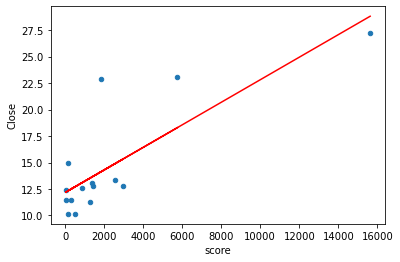

In [ ]:
# Linear regression - Weighted Sentiment


def regressionVisualizationWS(mergedData2):
    # create a scatter plot of the data
    mergedData2.plot(kind='scatter', x='Weighted_Sentiment', y='Close')

    # fitting the linear regression model to the data
    slope, intercept = np.polyfit(mergedData2['Weighted_Sentiment'], mergedData2['Close'], 1)

    # adding a regression line to the scatter plot
    plt.plot(mergedData2['Weighted_Sentiment'], slope*mergedData2['Weighted_Sentiment'] + intercept, color='red')

    #adding a title
    plt.title("Closing Price vs Daily Summed Weighted Sentiment")


    # add a description to the graph
    description = textwrap.wrap("This figure shows a scatter plot of the closing price of Game Stop vs weighted summed sentiment score of that day, and a line of best fit used for the linear regression. This graph demonstrates how positive sentiment towards Game Stop on Reddit correlates to a price increase of its stock.", width=60)

    plt.text(-20, -45,'\n'.join(description), fontsize=10, ha='left', va='bottom')

    #saving the sigure as a new file
    plt.savefig('regression_plot1.jpeg',dpi=300, bbox_inches = "tight")
    # plt.savefig('regression_plot1.jpeg')

    # show the plot
    plt.show()

In [ ]:
# Linear Regression - Score

def regressionVisualizationScore(mergedData2):
    # creating a scatter plot of the data
    mergedData2.plot(kind='scatter', x='score', y='Close')

    # fitting the linear regression model to the data
    slope, intercept = np.polyfit(mergedData2['score'], mergedData2['Close'], 1)

    # adding a regression line to the scatter plot
    plt.plot(mergedData2['score'], slope*mergedData2['score'] + intercept, color='red')

    #creating a title
    plt.title('Closing Price vs Daily Summed Score')

    # add a description to the graph
    description = textwrap.wrap("This figure shows a scatter plot of the closing price of Game Stop vs summed score (net upvotes) of that day, and a line of best fit used for the linear regression. This graph utilizes an alternative variable to demonstrate how positive sentiment towards Game Stop on Reddit correlates to a price increase of its stock.", width=60)

    plt.text(-20, -45,'\n'.join(description), fontsize=10, ha='left', va='bottom')

    #saving figure as new file
    plt.savefig('regression_plot2.jpeg',dpi=300, bbox_inches = "tight")

    # show the plot
    plt.show()

# Time Series Visualizations

<AxesSubplot:>

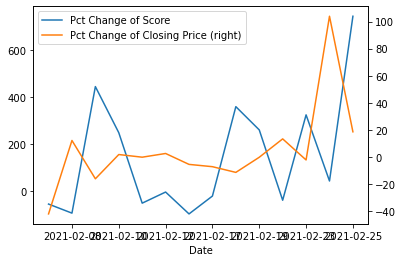

In [ ]:
#For Score

def timeSeriesVisualizationScore(mergedData2):
    fig, ax = plt.subplots() # Create the figure and axes object

    # Plotting date on the x axis and percent change of score (net upvotes) on the y axis
    mergedData2.plot(x = 'Date', y = 'Pct Change of Score', ax = ax) 

    #adding the percent change of closing price to the graph
    mergedData2.plot(x = 'Date', y = 'Pct Change of Closing Price', ax = ax, secondary_y = True) 
    plt.title('Percent Change of Score and Closing Price vs Time')

    # add a description to the graph
    description = textwrap.wrap("This figure shows how the summed daily score of comments mentioning Game Stop and Game Stop's stock price varies with time. This graph shows that changes in price preceed changes in score, suggesting that stock price changes is the leading variable.", width=60)

    plt.text(0, -280,'\n'.join(description), fontsize=10, ha='left', va='bottom')

    #saving the figure as a new file
    plt.savefig('time_series_plot1.jpeg',dpi=300, bbox_inches = "tight")

<AxesSubplot:xlabel='Pct Change of Score', ylabel='Pct Change of Closing Price'>

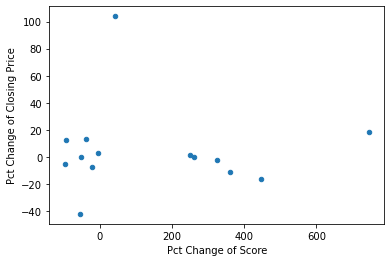

In [ ]:
# For Weighted Sentiment

def timeSeriesVisualizationWS(mergedData2):
    fig, ax = plt.subplots() # Create the figure and axes object

    # Plotting date on the x axis and percent change of weighted sentiment on the y axis
    mergedData2.plot(x = 'Date', y = 'Pct Change of WS', ax = ax) 

    #adding the percent change of closing price to the graph
    mergedData2.plot(x = 'Date', y = 'Pct Change of Closing Price', ax = ax, secondary_y = True) 
    plt.title('Percent Change of WS and Closing Price vs Time')

    # adding a description to the graph
    description = textwrap.wrap("This figure shows how the weighted daily sum of sentiment scores of comments mentioning Game Stop and Game Stop's stock price varies with time. This graph displays less of a clear relationship between the two variables, and suggests that the sentiment analysis package used may not be accurate at determining the true sentiment of comments regarding Game Stop.", width=60)

    plt.text(0, -340,'\n'.join(description), fontsize=10, ha='left', va='bottom')


    plt.savefig('time_series_plot2.jpeg',dpi=300, bbox_inches = "tight")